In [149]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input, Embedding, Dense, Concatenate, Flatten, Dropout,BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
import random
import numpy as np
# Read the CSV file
data = pd.read_csv("R.csv")

In [117]:
labels = data.copy()

feature_headings = [
    "d1","d2","d3","d4","d5","d6","First Layer","Second Layer"
]

input_features = labels[feature_headings]
output_values = labels[[c for c in labels.columns if c not in feature_headings]]
label_encoder = LabelEncoder()
input_features["First Layer"] = label_encoder.fit_transform(input_features["First Layer"])
input_features["Second Layer"] = label_encoder.transform(input_features["Second Layer"])

unique_materials = pd.unique(data[['First Layer', 'Second Layer']].values.ravel())


num_materials = len(unique_materials)
num_wavelengths = 351

input_train, input_test, output_train, output_test = train_test_split(input_features, output_values, test_size=0.2, random_state=42)
input_train, input_val, output_train, output_val = train_test_split(input_train, output_train, test_size=0.2, random_state=42)


/tmp/ipykernel_17053/1101238721.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_features["First Layer"] = label_encoder.fit_transform(input_features["First Layer"])
/tmp/ipykernel_17053/1101238721.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_features["Second Layer"] = label_encoder.transform(input_features["Second Layer"])


In [240]:

input_layer = Input(shape=(8,))

input_materials = input_layer[:, 6:8]
material_embedding = Embedding(input_dim=num_materials, output_dim=8)(input_materials)
material_embedding = Flatten()(material_embedding)

dense_layer1 = Dense(units=128, activation='PReLU')(input_layer)
dense_layer1 = BatchNormalization()(dense_layer1)  # Apply batch normalization

dense_layer2 = Dense(units=64, activation='PReLU')(dense_layer1)
dense_layer2 = BatchNormalization()(dense_layer2)  # Apply batch normalization

dense_layer3 = Dense(units=32, activation='PReLU')(dense_layer2)
dense_layer3 = BatchNormalization()(dense_layer3)  # Apply batch normalization

concatenated_features = Concatenate()([dense_layer3, material_embedding])

dense_layer4 = Dense(units=64, activation='PReLU')(concatenated_features)
dense_layer4 = BatchNormalization()(dense_layer4)  # Apply batch normalization

dense_layer5 = Dense(units=32, activation='PReLU')(dense_layer4)
dense_layer5 = BatchNormalization()(dense_layer5)  # Apply batch normalization

output_layer = Dense(units=num_wavelengths, activation='sigmoid')(dense_layer5)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

In [241]:

history=model.fit(input_train, output_train,validation_data=(input_val, output_val), epochs=10, batch_size=32)


Epoch 1/10
600/600 [==============================] - 8s 9ms/step - loss: 0.0459 - val_loss: 0.0165
Epoch 2/10
600/600 [==============================] - 4s 7ms/step - loss: 0.0167 - val_loss: 0.0128
Epoch 3/10
600/600 [==============================] - 4s 7ms/step - loss: 0.0142 - val_loss: 0.0095
Epoch 4/10
600/600 [==============================] - 4s 7ms/step - loss: 0.0109 - val_loss: 0.0070
Epoch 5/10
600/600 [==============================] - 4s 7ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 0.0075 - val_loss: 0.0047
Epoch 7/10
600/600 [==============================] - 4s 7ms/step - loss: 0.0066 - val_loss: 0.0041
Epoch 8/10
600/600 [==============================] - 4s 7ms/step - loss: 0.0061 - val_loss: 0.0039
Epoch 9/10
600/600 [==============================] - 5s 9ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 10/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0054 - val_loss: 0.0033

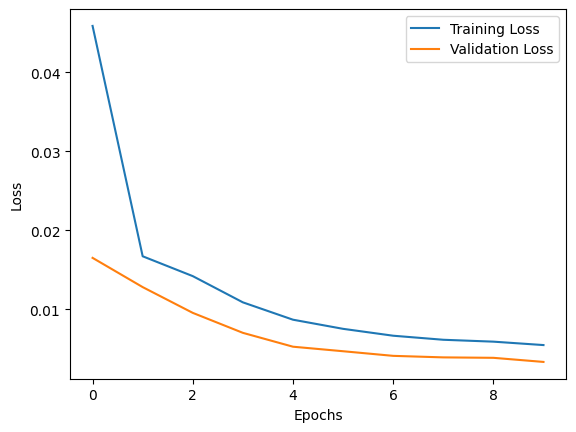

In [242]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 27ms/step


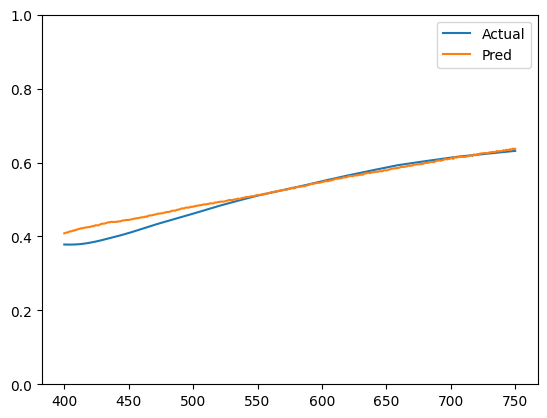

In [251]:
# Select a random index from the test set
index = random.randint(0, len(input_test) - 1)

# Get the corresponding input and output values
input_sample = input_test.iloc[[index]]
output_sample = output_test.iloc[[index]]

# Make a prediction for the selected sample
prediction = model.predict(input_sample)
output_sample = np.squeeze(output_sample)
prediction = np.squeeze(prediction)
fig,ax = plt.subplots()
x = np.arange(400,751)
ax.plot(x, output_sample, label='Actual')
ax.plot(x, prediction, label='Pred')
ax.set_ylim(0,1)
ax.legend()
plt.show()